In [1]:
import tensorflow as tf
from matplotlib import pyplot as plt

In [2]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape((60000, 28, 28, 1))
x_test = x_test.reshape((10000, 28, 28, 1))


x_train, x_test = x_train / 255.0, x_test / 255.0

In [3]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(5, (5, 5), padding='SAME', activation='relu', input_shape=(28, 28, 1)),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Conv2D(5, (5, 5), padding='SAME', activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Conv2D(20, (5, 5), padding='SAME', activation='relu'),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [4]:
model.fit(x_train, y_train, epochs=5)

model.evaluate(x_test,  y_test, verbose=2)

Epoch 1/5
1875/1875 [==============================] - 41s 22ms/step - loss: 0.1974 - accuracy: 0.9396
Epoch 2/5
1875/1875 [==============================] - 41s 22ms/step - loss: 0.0701 - accuracy: 0.9770
Epoch 3/5
1875/1875 [==============================] - 41s 22ms/step - loss: 0.0508 - accuracy: 0.9837
Epoch 4/5
1875/1875 [==============================] - 41s 22ms/step - loss: 0.0421 - accuracy: 0.9868
Epoch 5/5
1875/1875 [==============================] - 42s 23ms/step - loss: 0.0340 - accuracy: 0.9889
313/313 - 3s - loss: 0.0377 - accuracy: 0.9877


[0.0376606360077858, 0.9876999855041504]

In [5]:
def backprop_dense(activation, weight, bias, relevance):
  w = tf.maximum(0., weight)
  b = tf.maximum(0., bias)
  z = tf.matmul(activation, w) + b 
  s = relevance / z
  c = tf.matmul(s, tf.transpose(w))
  return activation * c


def backprop_conv(activation, weight, bias, relevance):
  strides = [1,1,1,1]
  w = tf.maximum(0., weight)
  b = tf.maximum(0., bias)
  z = tf.nn.conv2d(activation, w, strides, padding='SAME')
  z = tf.nn.bias_add(z, b)
  s = relevance / z
  c = tf.compat.v1.nn.conv2d_backprop_input(tf.shape(activation), w, s, strides, padding='SAME')
  return activation * c


from tensorflow.python.ops import gen_nn_ops
def backprop_pooling(activation, relevance):
  # kernel size, strides
  # if z is zero
  ksize = strides = [1, 2, 2, 1]
  z = tf.nn.max_pool(activation, ksize, strides, padding='SAME') + 1e-10
  s = relevance / z
  # input, argmax, argmax_mask
  c = gen_nn_ops.max_pool_grad(activation, z, s, ksize, strides, padding='SAME')
  return activation * c

In [6]:
def getLRP(img):
  activations = []
  prev_activation = img.reshape(-1, 28,28, 1)
  for layer in model.layers:
    prev_activation = layer(prev_activation)
    activations.append(prev_activation)
  
  # Dense
  R4 = activations[6]

  # fully connected
  a = activations[4]
  w = model.layers[6].kernel
  b = model.layers[6].bias
  R3 = backprop_dense(tf.reshape(a,[1, 980]), w, b, R4)

  # conv
  w = model.layers[4].kernel
  b = model.layers[4].bias
  p = activations[3]
  a = activations[1]
  R_conv = backprop_conv(p, w, b, tf.reshape(R3, [1, 7, 7, 20]))
  R2 = backprop_pooling(a, R_conv)

  # conv
  w = model.layers[2].kernel
  b = model.layers[2].bias
  p = activations[1]
  a = activations[0]
  R_conv = backprop_conv(p, w, b, R2)
  R1 = backprop_pooling(a, R_conv)

  w = model.layers[0].kernel
  b = model.layers[0].bias
  R0 = backprop_conv(img.reshape(-1, 28,28, 1), w, b, R1)


  return R0


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



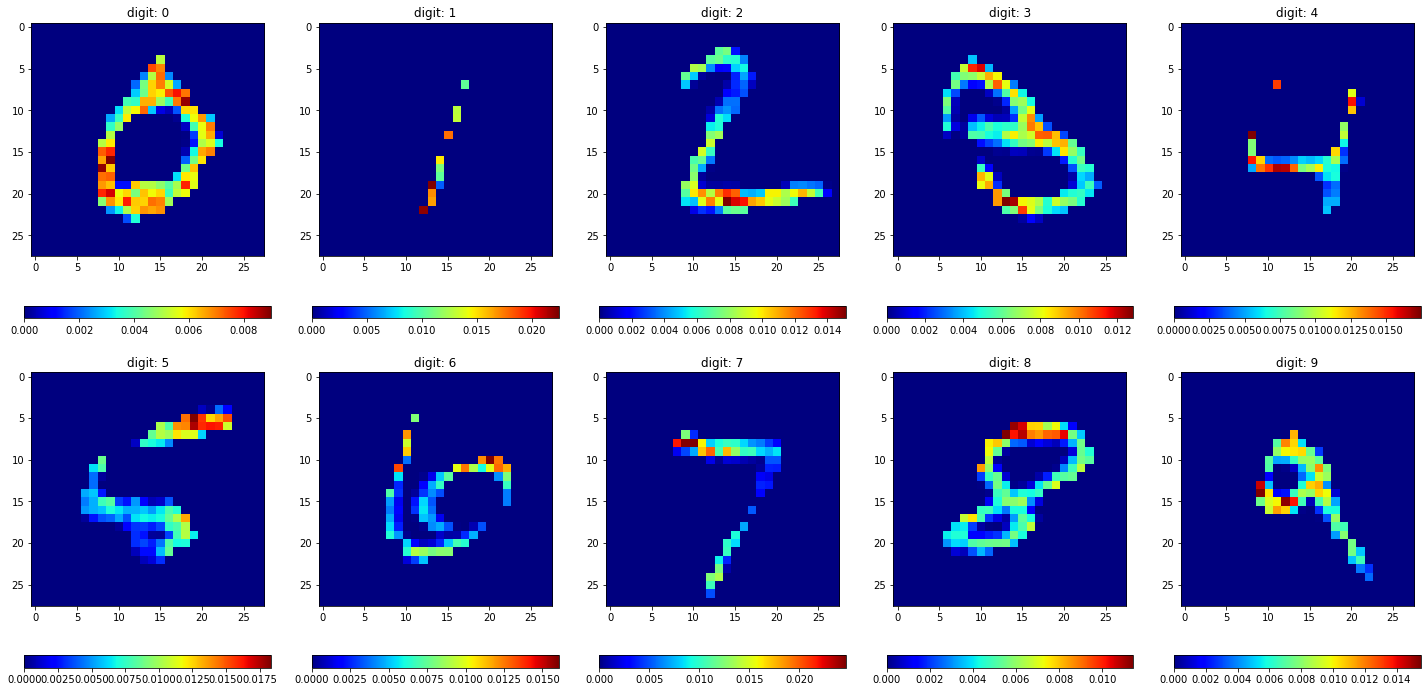

In [7]:
import numpy as np
import math
# get MNIST dataset index dict
mnist_dict = {}
idx = 0
for label in y_test:
  if mnist_dict.get(label):
    mnist_dict[label].append(idx)
  else:
    mnist_dict[label] = [idx]
  idx += 1

# get LRP
nums = []
for i in range(10):
  img_idx = mnist_dict[i][0]
  img = x_test[img_idx]
  lrp = getLRP(img)
  nums.append(lrp)

# plot images
plt.figure(figsize=(20,10))
for i in range(2):
  for j in range(5):
    idx = 5 * i + j
    plt.subplot(2, 5, idx + 1)
    plt.title('digit: {}'.format(idx))

    result = tf.reshape(nums[idx], [28, 28])
    result = result.numpy()
    result = np.nan_to_num(result)

    plt.imshow(result, cmap=plt.cm.jet)
    plt.colorbar(orientation='horizontal')
plt.tight_layout()